In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

import networkx as nx

from coppeliasim_zmqremoteapi_client import RemoteAPIClient 

def Rz(theta):
  
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])


# def Rz(theta):
  
#     return np.array([[ np.cos(theta), -np.sin(theta) ],
#                       [ np.sin(theta), np.cos(theta)]])

## Processamento de imagem

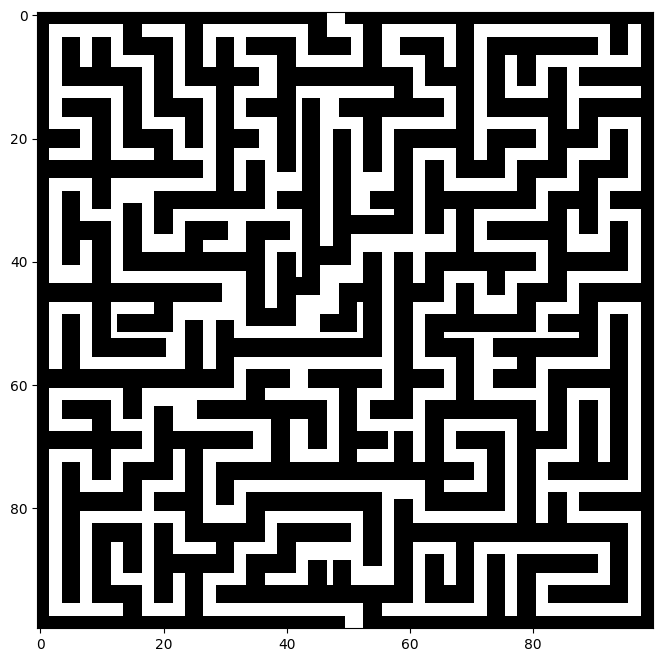

In [20]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Invertendo os valores para visualização (Branco - 0, Preto - 1)
img = mpimg.imread('../../testes/new_maze_expand.png').astype(float)

if img.ndim == 3:
    img = img[:, :, 0]

img = 1 - img

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')

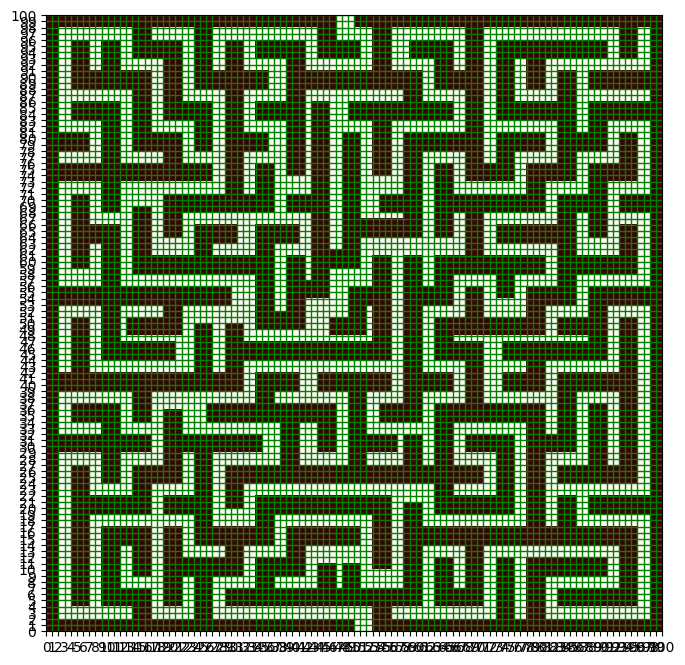

In [21]:
# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array([100, 100]) # Cave 

# Escala Pixel/Metro
sy, sx = img.shape[:2] / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = 1

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como ocupadas (1) ou Não-ocupadas (0)       
grid[grid > threshold] = 1
grid[grid<= threshold] = 0        

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Plotando Mapa e Células

obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

# Plotando as linhas do grid para facilitar a visualização
ax.grid(which='major', axis='both', linestyle='-', color='green', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

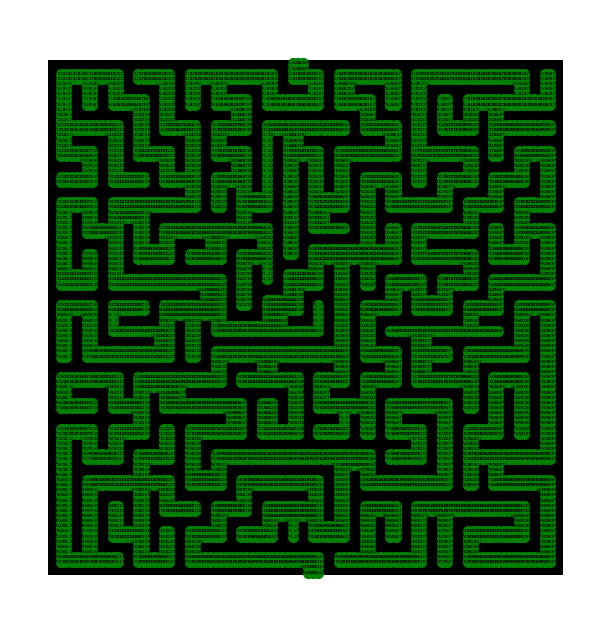

In [22]:
# Criando o Grafo para o nosso Grid

# Criando vértices em todas as células
G = nx.grid_2d_graph(rows, cols) 

# Removendo células que estão em células marcas com obstáculos
for r in range(rows):
    for c in range(cols):
        if grid[r][c] == 1:  
            G.remove_node((r,c))


fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Grid
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

# Os vértices serão plotados no centro da célula  
pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}
nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

In [24]:
print(G.nodes())

[(0, 47), (0, 48), (0, 49), (1, 47), (1, 48), (1, 49), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 56), (2, 57), (2, 58), (2, 59), (2, 60), (2, 61), (2, 62), (2, 63), (2, 64), (2, 65), (2, 66), (2, 67), (2, 71), (2, 72), (2, 73), (2, 74), (2, 75), (2, 76), (2, 77), (2, 78), (2, 79), (2, 80), (2, 81), (2, 82), (2, 83), (2, 84), (2, 85), (2, 86), (2, 87), (2, 88), (2, 89), (2, 90), (2, 91), (2, 92), (2, 96), (2, 97), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36)

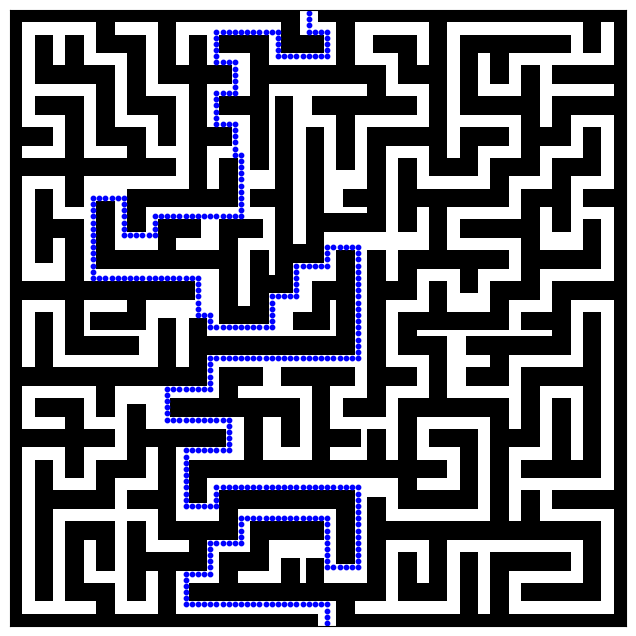

In [27]:
# Finalmente podemos determinar o menor caminho entre duas células
# ATENÇÃO para o Sistema de Coordenadas -- relação Índice do grid e Posição no mundo

start_node =  (0, 48)
end_node = (99, 51)


fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Mapa
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

# Caminho
path = nx.shortest_path(G, source=start_node, target=end_node)
nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=10, node_color='b')

## teste

In [ ]:
def mapa(image_caminho,start_node,end_node,escala_imagem,tamanho_cell):

    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Invertendo os valores para visualização (Branco - 0, Preto - 1)

    img = mpimg.imread(image_caminho).astype(float)

    if img.ndim == 3:
        img = img[:, :, 0]

    img = 1 - img

    # Apenas para garantir que só teremos esses dois valores
    threshold = 0.5
    img[img > threshold] = 1
    img[img<= threshold] = 0

    # Dimensões do mapa informado em metros (X, Y)
    map_dims = np.array(escala_imagem)

    # Escala Pixel/Metro
    sy, sx = img.shape[:2] / map_dims

    # Tamanho da célula do nosso Grid (em metros)
    cell_size = tamanho_cell

    rows, cols = (map_dims / cell_size).astype(int)
    grid = np.zeros((rows, cols))

    # Preenchendo o Grid
    # Cada célula recebe o somatório dos valores dos Pixels
    for r in range(rows):
        for c in range(cols):
            
            xi = int(c*cell_size*sx)
            xf = int(xi + cell_size*sx)
            
            yi = int(r*cell_size*sy)
            yf = int(yi + cell_size*sy)
                        
            grid[r, c] = np.sum(img[yi:yf,xi:xf])
            
    # Binarizando as células como ocupadas (1) ou Não-ocupadas (0)       
    grid[grid > threshold] = 1
    grid[grid<= threshold] = 0   

    # Criando o Grafo para o nosso Grid

    # Criando vértices em todas as células
    G = nx.grid_2d_graph(rows, cols) 
    G_complete = G.copy()

    # Removendo células que estão em células marcas com obstáculos
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == 1:  
                G.remove_node((r,c))

    # Os vértices serão plotados no centro da célula  
    pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}

    # Mapa
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

    # Caminho
    path = nx.shortest_path(G, source=start_node, target=end_node)
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')

    return pos, path


# mapa('../mapas_meus/teste1_invertido.png',(5,5),(37,37))

# pos, path = mapa('../mapas_meus/teste1_invertido.png',(5,5),(27,57))

# pos, path = mapa('../mapas_meus/teste1_invertido.png',(5,5),(27,57))


In [ ]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math


def pixel_to_world(x_px, y_px, img_size=65, world_size=10):
    """
    Converte coordenadas de pixel (imagem) para coordenadas do CoppeliaSim (metros).
    """
    scale = world_size / img_size  # m/pixel
    x_world = (x_px - img_size/2) * scale
    y_world = (y_px - img_size/2) * scale 
    return x_world, y_world



# --- Configurações ---
MAP_IMAGE_PATH = '../mapas_meus/teste1_invertido.png'
MAP_DIMS_METERS = np.array([25.0, 25.0]) # Dimensões REAIS do mapa em metros (Altura, Largura)
CELL_SIZE_METERS = 0.5 # Tamanho da célula do grid em metros
ROBOT_RADIUS_METERS = 0.3 # Raio do robô para inflar obstáculos

# --- Preparação da Figura ---
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# --- Carregamento e Processamento do Mapa ---
# Carrega a imagem e converte para float
img = mpimg.imread(MAP_IMAGE_PATH).astype(float)

# Garante que a imagem tenha apenas um canal (escala de cinza)
if img.ndim == 3:
    img = img[:, :, 0]

# Inverte a imagem: obstáculos devem ser 1, espaço livre 0
img = 1 - img

# Binariza a imagem para garantir apenas valores 0 e 1
threshold = 0.5
img[img > threshold] = 1
img[img <= threshold] = 0

# --- Criação da Grade de Ocupação ---
h_pixels, w_pixels = img.shape
# Escala Pixel/Metro
sy = h_pixels / MAP_DIMS_METERS[0]
sx = w_pixels / MAP_DIMS_METERS[1]

# Dimensões da grade em número de células
rows = int(MAP_DIMS_METERS[0] / CELL_SIZE_METERS)
cols = int(MAP_DIMS_METERS[1] / CELL_SIZE_METERS)
grid = np.zeros((rows, cols))

# Preenche a grade baseando-se nos pixels do mapa
for r in range(rows):
    for c in range(cols):
        # Converte a célula (r, c) de volta para coordenadas de pixel
        y_start_px = int(r * CELL_SIZE_METERS * sy)
        y_end_px = int((r + 1) * CELL_SIZE_METERS * sy)
        x_start_px = int(c * CELL_SIZE_METERS * sx)
        x_end_px = int((c + 1) * CELL_SIZE_METERS * sx)
        
        # Se a soma dos pixels na área for maior que 0, a célula contém um obstáculo
        grid[r, c] = np.sum(img[y_start_px:y_end_px, x_start_px:x_end_px])

# Binariza a grade final
grid[grid > threshold] = 1
grid[grid <= threshold] = 0

# --- Inflação dos Obstáculos (Configuration Space) ---
# Calcula o número de células para inflar com base no raio do robô
inflation_in_cells = math.ceil(ROBOT_RADIUS_METERS / CELL_SIZE_METERS)
if inflation_in_cells == 0: inflation_in_cells = 1 # Garante inflação mínima

print(f"Raio do robô: {ROBOT_RADIUS_METERS}m, Tamanho da célula: {CELL_SIZE_METERS}m")
print(f"Inflando obstáculos em {inflation_in_cells} célula(s).")

kernel = np.ones((3,3), dtype=np.uint8)
grid_inflated = cv2.dilate(grid.astype(np.uint8), kernel, iterations=inflation_in_cells)


# --- Criação do Grafo para Planejamento ---
G = nx.grid_2d_graph(rows, cols)

# Remove os nós do grafo que correspondem a obstáculos na grade INFLADA
for r in range(rows):
    for c in range(cols):
        if grid_inflated[r, c] == 1:
            G.remove_node((r, c))

# Posição dos nós para visualização (invertendo o eixo Y para corresponder à imagem)
pos = {node: (node[1] * CELL_SIZE_METERS + CELL_SIZE_METERS / 2, 
              MAP_DIMS_METERS[0] - node[0] * CELL_SIZE_METERS - CELL_SIZE_METERS / 2) 
       for node in G.nodes()}

# --- NOVA FUNÇÃO DE CONVERSÃO ---
def grid_to_world_coppelia(row, col, map_dims_meters, cell_size_meters):
    """
    Converte coordenadas da grade (row, col) para coordenadas do mundo CoppeliaSim (metros).
    Assume que a origem (0,0) do CoppeliaSim está no centro do mapa.
    """
    # 1. Calcula a posição em metros a partir do canto inferior esquerdo
    # Posição X:
    world_x = col * cell_size_meters + (cell_size_meters / 2)
    # Posição Y (invertendo o eixo 'row' que começa de cima):
    rows = int(map_dims_meters[0] / cell_size_meters)
    world_y = (rows - 1 - row) * cell_size_meters + (cell_size_meters / 2)
    
    # 2. Translada a origem para o centro do mapa
    world_x -= map_dims_meters[1] / 2
    world_y -= map_dims_meters[0] / 2
    
    return world_x, world_y


# --- Planejamento de Caminho ---
start_node = (5, 5) # (linha, coluna)
end_node = (45, 25) # (linha, coluna)

# Visualização
ax.imshow(grid_inflated, cmap='Greys', extent=(0, MAP_DIMS_METERS[1], 0, MAP_DIMS_METERS[0]))

# Validação dos nós e cálculo do caminho
if not G.has_node(start_node):
    print(f"Erro: O nó de início {start_node} não é válido (provavelmente está em um obstáculo).")
elif not G.has_node(end_node):
    print(f"Erro: O nó de destino {end_node} não é válido.")
else:
    print("Calculando o caminho mais curto...")
    path = nx.shortest_path(G, source=start_node, target=end_node)
    
    # Desenha os nós do caminho na visualização do Matplotlib
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=50, node_color='b')
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='b', width=1.5)

    # --- CONVERSÃO CORRETA PARA O COPPELIASIM ---
    # Converte o caminho (lista de nós) em uma lista de coordenadas (x, y) para o robô seguir
    path_world = []
    for node in path:
        row, col = node
        x_world, y_world = grid_to_world_coppelia(row, col, MAP_DIMS_METERS, CELL_SIZE_METERS)
        path_world.append((x_world, y_world))

    # Exemplo: Posição inicial do robô no CoppeliaSim
    start_pos_coppelia = path_world[0]
    print(f"\nPosição inicial do robô no CoppeliaSim (X, Y): {start_pos_coppelia}")

    # Exemplo: Posição final do robô no CoppeliaSim
    end_pos_coppelia = path_world[-1]
    print(f"Posição final do robô no CoppeliaSim (X, Y): {end_pos_coppelia}")
    
    # A variável 'path_world_coords' agora contém a lista de pontos que seu robô deve seguir.
    # print("\nCaminho completo em coordenadas do CoppeliaSim:")
    # print(path_world_coords)

plt.show()



# pos, path = mapa('../mapas_meus/mapa_convertido.png',(65, 65),(0,0),(209,208),5)

# Informacao do robotino
L = 0.135  # distancia do centro as rodas (m)
r = 0.040  # raio das rodas (m)


# pos_world = {node: pixel_to_world(x_px, y_px, 65, 10) for node, (x_px, y_px) in pos.items()}

# pos_world = pos


# pos_world = {node: pixel_to_world(x_px, y_px, 1259, 20) for node, (x_px, y_px) in pos.items()}
# Cinematica Inversa Holonomico
Minv =  np.array([
    [-(np.sqrt(3)/2),    1/2   ,    L],
    [      0      ,    -1    ,    L],
    [(np.sqrt(3)/2),    1/2   ,    L]
    ]) * (1 / r)


# Posicao inicial do robo - o mesmo da caminho
start_node = path[0]
start_pos_world = pos_world[start_node]
start_pos_sim = [start_pos_world[0], start_pos_world[1], 0.08]
start_ori_sim = [0, 0, np.deg2rad(90)]


# Conexao Coppelia
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

robotname = 'robotino'
robotHandle = sim.getObject(f'/{robotname}')

wheel1 = sim.getObject(f'/{robotname}/wheel0_joint')
wheel2 = sim.getObject(f'/{robotname}/wheel1_joint')
wheel3 = sim.getObject(f'/{robotname}/wheel2_joint')


# Parar a simulação se estiver executando
initial_sim_state = sim.getSimulationState()
if initial_sim_state != 0:
    sim.stopSimulation()
    time.sleep(1)

sim.startSimulation()
sim.setObjectPosition(robotHandle, sim.handle_world, start_pos_sim)
sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori_sim)
sim.step()

# Estado inicial
q = np.array([start_pos_sim[0], start_pos_sim[1], start_ori_sim[2]])

print("Iniciando o caminho")

# Caminhos a ser seguidos
waypoints = [pos_world[node] for node in path]
target_index = 0
tolerance = 0.2

while target_index < len(waypoints):
    target = np.array(waypoints[target_index])
    pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
    q[:2] = pos_sim[:2]

    # Erro no referencial do mundo
    erro = target - q[:2]
    dist = np.linalg.norm(erro)

    # Controlador proporcional
    vx_world = 0.7 * erro[0]
    vy_world = 0.7 * erro[1]

    # Limita velocidades
    vx_world = np.clip(vx_world, -0.3, 0.3)
    vy_world = np.clip(vy_world, -0.3, 0.3)

    # Converte velocidade do mundo → corpo (mantendo orientação fixa)
    v_body = Rz(-start_ori_sim[2]) @ np.array([vx_world, vy_world, 0.04])


    # vz_body e descartado por ser 0
    vx_body, vy_body , vz_body = v_body
    w = 0.0  # sem rotação

    # Calcula velocidades das rodas
    qdot = np.array([vx_body, vy_body, w])

    
    u = Minv @ qdot  # usa cinemática inversa para gerar rodas

    # Envia velocidades
    sim.setJointTargetVelocity(wheel1, u[0])
    sim.setJointTargetVelocity(wheel2, u[1])
    sim.setJointTargetVelocity(wheel3, u[2])

    # Avança um passo
    sim.step()

    # Verifica se chegou
    if dist < tolerance:
        print(f"Chegou em {path[target_index]} -> indo para o próximo ponto")
        target_index += 1


print("Caminho concluído! Parando robô...")
for w in [wheel1, wheel2, wheel3]:
    sim.setJointTargetVelocity(w, 0)

pos_final = sim.getObjectPosition(robotHandle, sim.handle_world)
print("Posição final (SIM):", pos_final)
sim.stopSimulation()
print("Program ended.")


In [ ]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import time
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# --- DEFINIÇÃO DE FUNÇÕES AUXILIARES ---

def grid_to_world_coppelia(row, col, map_dims_meters, cell_size_meters):
    """
    Converte coordenadas da grade (row, col) para coordenadas do mundo CoppeliaSim (metros).
    Assume que a origem (0,0) do CoppeliaSim está no centro do mapa.
    """
    # Posição X:
    # Cálculo direto para X e Y
    world_x = col * cell_size_meters + (cell_size_meters / 2)
    world_y = row * cell_size_meters + (cell_size_meters / 2)
    
    # Translada a origem para o centro do mapa
    world_x -= map_dims_meters[1] / 2
    world_y -= map_dims_meters[0] / 2
    
    return world_x, world_y

def Rz(theta):
    """
    Cria uma matriz de rotação 2D em torno do eixo Z.
    """
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

# --- CONFIGURAÇÕES GERAIS ---
MAP_IMAGE_PATH = '../mapas_meus/teste1_invertido.png'
MAP_DIMS_METERS = np.array([25.0, 25.0]) # Dimensões REAIS do mapa em metros (Altura, Largura)
CELL_SIZE_METERS = 0.5 # Tamanho da célula do grid em metros
ROBOT_RADIUS_METERS = 0.3 # Raio do robô para inflar obstáculos

# ===================================================================
# ETAPA 1: PLANEJAMENTO DE CAMINHO
# ===================================================================

# --- Carregamento e Processamento do Mapa ---
img = mpimg.imread(MAP_IMAGE_PATH).astype(float)
if img.ndim == 3:
    img = img[:, :, 0]
img = 1 - img
threshold = 0.5
img[img > threshold] = 1
img[img <= threshold] = 0

# --- Criação da Grade de Ocupação ---
h_pixels, w_pixels = img.shape
sy = h_pixels / MAP_DIMS_METERS[0]
sx = w_pixels / MAP_DIMS_METERS[1]

rows = int(MAP_DIMS_METERS[0] / CELL_SIZE_METERS)
cols = int(MAP_DIMS_METERS[1] / CELL_SIZE_METERS)
grid = np.zeros((rows, cols))

for r in range(rows):
    for c in range(cols):
        y_start_px = int(r * CELL_SIZE_METERS * sy)
        y_end_px = int((r + 1) * CELL_SIZE_METERS * sy)
        x_start_px = int(c * CELL_SIZE_METERS * sx)
        x_end_px = int((c + 1) * CELL_SIZE_METERS * sx)
        grid[r, c] = np.sum(img[y_start_px:y_end_px, x_start_px:x_end_px])

grid[grid > threshold] = 1
grid[grid <= threshold] = 0

# --- Inflação dos Obstáculos ---
inflation_in_cells = math.ceil(ROBOT_RADIUS_METERS / CELL_SIZE_METERS)
if inflation_in_cells == 0: inflation_in_cells = 1
kernel = np.ones((3,3), dtype=np.uint8)
grid_inflated = cv2.dilate(grid.astype(np.uint8), kernel, iterations=inflation_in_cells)

# --- Criação do Grafo e Busca de Caminho ---
G = nx.grid_2d_graph(rows, cols)
for r in range(rows):
    for c in range(cols):
        if grid_inflated[r, c] == 1:
            G.remove_node((r, c))

start_node = (5, 5) # (linha, coluna)
end_node = (45, 25) # (linha, coluna)

if not G.has_node(start_node) or not G.has_node(end_node):
    print("Erro: Nó de início ou de destino inválido (em cima de um obstáculo).")
    exit()

print("Calculando o caminho mais curto...")
path_nodes = nx.shortest_path(G, source=start_node, target=end_node)

# --- Conversão do Caminho para Coordenadas do CoppeliaSim ---
path_world = []
for node in path_nodes:
    row, col = node
    x_world, y_world = grid_to_world_coppelia(row, col, MAP_DIMS_METERS, CELL_SIZE_METERS)
    path_world.append((x_world, y_world))

print(f"Posição inicial no CoppeliaSim (X, Y): {path_world[0]}")
print(f"Posição final no CoppeliaSim (X, Y): {path_world[-1]}")

# ===================================================================
# ETAPA 2: VISUALIZAÇÃO (OPCIONAL)
# ===================================================================
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')
pos_visualization = {node: (node[1] * CELL_SIZE_METERS + CELL_SIZE_METERS / 2, 
                           MAP_DIMS_METERS[0] - node[0] * CELL_SIZE_METERS - CELL_SIZE_METERS / 2) 
                     for node in G.nodes()}
ax.imshow(grid_inflated, cmap='Greys', extent=(0, MAP_DIMS_METERS[1], 0, MAP_DIMS_METERS[0]))
path_edges = list(zip(path_nodes, path_nodes[1:]))
nx.draw_networkx_nodes(G, pos_visualization, nodelist=path_nodes, node_size=50, node_color='b')
nx.draw_networkx_edges(G, pos_visualization, edgelist=path_edges, edge_color='b', width=1.5)


# ===================================================================
# ETAPA 3: CONTROLE NO COPPELIASIM
# ===================================================================

# --- Informações do Robotino ---
L = 0.135  # Distância do centro às rodas (m)
r = 0.040  # Raio das rodas (m)

# Matriz de Cinemática Inversa
Minv = np.array([
    [-(np.sqrt(3)/2), 1/2, L],
    [0, -1, L],
    [(np.sqrt(3)/2), 1/2, L]
]) * (1 / r)

# --- Conexão com o CoppeliaSim ---
client = RemoteAPIClient()
sim = client.require("sim")

# --- Obtenção dos Handles ---
robotname = 'robotino'
robotHandle = sim.getObject(f'/{robotname}')
wheel1 = sim.getObject(f'/{robotname}/wheel0_joint')
wheel2 = sim.getObject(f'/{robotname}/wheel1_joint')
wheel3 = sim.getObject(f'/{robotname}/wheel2_joint')

# --- Preparação da Simulação ---
sim.stopSimulation(False) # Para a simulação se estiver rodando
time.sleep(1) # Pequena pausa

# --- Posição Inicial do Robô ---
# CORREÇÃO: Usar a primeira coordenada da lista 'path_world'
start_pos_sim = [path_world[0][0], path_world[0][1], 0.04] 
start_ori_sim = [0, 0, np.deg2rad(90)] # Orientação inicial (90 graus)

sim.setObjectPosition(robotHandle, -1, start_pos_sim)
sim.setObjectOrientation(robotHandle, -1, start_ori_sim)

sim.startSimulation()
print("Iniciando o caminho no CoppeliaSim...")

# --- Loop de Controle ---
# CORREÇÃO: Usar a variável 'path_world' como a lista de waypoints
waypoints = path_world
target_index = 0
tolerance = 0.15 # Tolerância para considerar que o robô chegou ao ponto

while target_index < len(waypoints):
    # Posição alvo atual
    target_pos = np.array(waypoints[target_index])
    
    # Posição atual do robô na simulação
    current_pos_sim = sim.getObjectPosition(robotHandle, -1)
    current_pos = np.array(current_pos_sim[:2])

    # Erro de posição no referencial do mundo
    error = target_pos - current_pos
    distance_to_target = np.linalg.norm(error)

    # Verifica se o robô chegou ao alvo
    if distance_to_target < tolerance:
        print(f"Alvo {target_index} alcançado! Indo para o próximo.")
        target_index += 1
        if target_index >= len(waypoints):
            break # Sai do loop se for o último ponto
        continue # Pula para a próxima iteração

    # Controlador Proporcional para velocidade no referencial do MUNDO
    k_p = 0.5 # Ganho proporcional
    vx_world = k_p * error[0]
    vy_world = k_p * error[1]

    # Limita a velocidade máxima
    max_speed = 0.5
    speed = np.linalg.norm([vx_world, vy_world])
    if speed > max_speed:
        vx_world = (vx_world / speed) * max_speed
        vy_world = (vy_world / speed) * max_speed

    # Converte a velocidade do MUNDO para o referencial do ROBÔ
    # A orientação do robô é mantida fixa em 90 graus
    current_orientation = start_ori_sim[2] 
    v_body_2d = Rz(-current_orientation) @ np.array([vx_world, vy_world])
    vx_body = v_body_2d[0]
    vy_body = v_body_2d[1]
    w_body = 0.0  # Sem rotação, orientação fixa

    # Calcula as velocidades das rodas via cinemática inversa
    q_dot_body = np.array([vx_body, vy_body, w_body])
    wheel_speeds = Minv @ q_dot_body

    # Envia as velocidades para as juntas das rodas
    sim.setJointTargetVelocity(wheel1, wheel_speeds[0])
    sim.setJointTargetVelocity(wheel2, wheel_speeds[1])
    sim.setJointTargetVelocity(wheel3, wheel_speeds[2])
    
    time.sleep(0.01) # Pequena pausa para não sobrecarregar

# --- Finalização ---
print("Caminho concluído! Parando o robô...")
for w in [wheel1, wheel2, wheel3]:
    sim.setJointTargetVelocity(w, 0)

time.sleep(1)
sim.stopSimulation()
print("Simulação finalizada.")

# CORREÇÃO: Mover o plt.show() para o final para não bloquear o script
plt.show()

## Execução do codigo

In [ ]:
def pixel_to_world(x_px, y_px, img_size=65, world_size=10):
    """
    Converte coordenadas de pixel (imagem) para coordenadas do CoppeliaSim (metros).
    """
    scale = world_size / img_size  # m/pixel
    x_world = (x_px - img_size/2) * scale
    y_world = (y_px - img_size/2) * scale 
    return x_world, y_world


def pixel_to_world(x_px, y_px, img_l, img_h, world_size=10):
    """
    Converte coordenadas de pixel (imagem) para coordenadas do CoppeliaSim (metros).
    """
    scale = world_size / max(img_l, img_h)  # metros por pixel
    x_world = (x_px - img_l / 2) * scale
    y_world = (y_px - img_h / 2) * scale
    return x_world, y_world



In [ ]:
pos, path = mapa('../mapas_meus/maze_circula_invertido.png',(5,5),(57,47))

In [ ]:
pos, path = mapa('../mapas_meus/teste1_invertido.png',(5, 5),(57,47),(64,64),1)
# pos, path = mapa('../mapas_meus/circular_maze.png',(65, 65),(0,0),(1250,1250),5)

In [ ]:
from shapely.geometry import Polygon
from shapely.geometry import Point

pos, path = mapa('../mapas_meus/mapa_convertido.png',(65, 65),(0,0),(209,208),5)

R = 3

obs_set_dilated = [obs.buffer(R) for obs in obs_set]

plot_map(obs_set) 


for n in G_complet.nodes():
    if n not in G.nodes():
        x, y = pos[n]
        plt.gca().add_patch(plt.Circle((x, y), R, color='red', alpha=0.5))

obs_set_dilated = []
for obs in obs_set:
    obs_set_dilated.append(obs.buffer(R))



plot_map(obs_set)    
    
for obs in obs_set_dilated:
    plt.gca().add_patch(PolygonPatch(obs, facecolor='red', alpha=.5, zorder=0))  
    

# Robô
robot = Point([7, 23]).buffer(R)
plt.gca().add_patch(PolygonPatch(robot, facecolor='blue', alpha=.5))

In [50]:
def pixel_to_world(x_px, y_px, img_size, world_size):
    """
    Converte coordenadas de pixel (imagem) para coordenadas do CoppeliaSim (metros).
    """
    scale = world_size / img_size  # m/pixel
    x_world = (x_px + 0.1  - img_size/2) * scale
    y_world = (y_px + 0.1 - img_size/2) * scale 
    return x_world, y_world



In [38]:
#original fucional


# pos, path = mapa('../mapas_meus/mapa_convertido.png',(65, 65),(0,0),(209,208),5)

# Informacao do robotino
L = 0.135  # distancia do centro as rodas (m)
r = 0.040  # raio das rodas (m)


pos_world = {node: pixel_to_world(x_px, y_px, 100, 20) for node, (x_px, y_px) in pos.items()}

# pos_world = pos


# pos_world = {node: pixel_to_world(x_px, y_px, 1259, 20) for node, (x_px, y_px) in pos.items()}
# Cinematica Inversa Holonomico
Minv =  np.array([
    [-(np.sqrt(3)/2),    1/2   ,    L],
    [      0      ,    -1    ,    L],
    [(np.sqrt(3)/2),    1/2   ,    L]
    ]) * (1 / r)

# Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])


# Posicao inicial do robo - o mesmo da caminho
start_node = path[0]
start_pos_world = pos_world[start_node]
start_pos_sim = [start_pos_world[0], start_pos_world[1], 0.08]
start_ori_sim = [0, 0, np.deg2rad(90)]


# Conexao Coppelia
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

robotname = 'robotino'
robotHandle = sim.getObject(f'/{robotname}')

wheel1 = sim.getObject(f'/{robotname}/wheel0_joint')
wheel2 = sim.getObject(f'/{robotname}/wheel1_joint')
wheel3 = sim.getObject(f'/{robotname}/wheel2_joint')


# Parar a simulação se estiver executando
initial_sim_state = sim.getSimulationState()
if initial_sim_state != 0:
    sim.stopSimulation()
    time.sleep(1)

sim.startSimulation()
sim.setObjectPosition(robotHandle, sim.handle_world, start_pos_sim)
sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori_sim)
sim.step()

# Estado inicial
q = np.array([start_pos_sim[0], start_pos_sim[1], start_ori_sim[2]])

print("Iniciando o caminho")

# Caminhos a ser seguidos
waypoints = [pos_world[node] for node in path]
target_index = 0
tolerance = 0.2

while target_index < len(waypoints):

    dt = sim.getSimulationTimeStep()
    target = np.array(waypoints[target_index])
    pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
    q[:2] = pos_sim[:2]

    # Erro no referencial do mundo
    erro = target - q[:2]
    dist = np.linalg.norm(erro)

    # Controlador proporcional
    vx_world = 0.7 * erro[0]
    vy_world = 0.7 * erro[1]

    # Limita velocidades
    vx_world = np.clip(vx_world, -0.3, 0.3)
    vy_world = np.clip(vy_world, -0.3, 0.3)

    # Converte velocidade do mundo → corpo (mantendo orientação fixa)
    v_body = Rz(-start_ori_sim[2]) @ np.array([vx_world, vy_world, 0.04])


    # vz_body e descartado por ser 0
    vx_body, vy_body , vz_body = v_body
    w = 0.0  # sem rotação

    # Calcula velocidades das rodas
    qdot = np.array([vx_body, vy_body, w])

    u = Minv @ qdot  # usa cinemática inversa para gerar rodas

    # Envia velocidades
    sim.setJointTargetVelocity(wheel1, u[0])
    sim.setJointTargetVelocity(wheel2, u[1])
    sim.setJointTargetVelocity(wheel3, u[2])

    # Avança um passo
    sim.step()

    # Verifica se chegou
    if dist < tolerance:
        print(f"Chegou em {path[target_index]} -> indo para o próximo ponto")
        target_index += 1


print("Caminho concluído! Parando robô...")
for w in [wheel1, wheel2, wheel3]:
    sim.setJointTargetVelocity(w, 0)

pos_final = sim.getObjectPosition(robotHandle, sim.handle_world)
print("Posição final (SIM):", pos_final)
sim.stopSimulation()
print("Program ended.")


0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


KeyboardInterrupt: 

In [51]:
#brincando com a funcao


# pos, path = mapa('../mapas_meus/mapa_convertido.png',(65, 65),(0,0),(209,208),5)

# Informacao do robotino
L = 0.135  # distancia do centro as rodas (m)
r = 0.040  # raio das rodas (m)


pos_world = {node: pixel_to_world(x_px, y_px, 100, 20) for node, (x_px, y_px) in pos.items()}

# pos_world = pos


# pos_world = {node: pixel_to_world(x_px, y_px, 1259, 20) for node, (x_px, y_px) in pos.items()}
# Cinematica Inversa Holonomico
Minv =  np.array([
    [-(np.sqrt(3)/2),    1/2   ,    L],
    [      0      ,    -1    ,    L],
    [(np.sqrt(3)/2),    1/2   ,    L]
    ]) * (1 / r)

# Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])


# Posicao inicial do robo - o mesmo da caminho
start_node = path[0]
start_pos_world = pos_world[start_node]
start_pos_sim = [start_pos_world[0], start_pos_world[1], 0.08]
start_ori_sim = [0, 0, np.deg2rad(90)]


# Conexao Coppelia
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

robotname = 'robotino'
robotHandle = sim.getObject(f'/{robotname}')

wheel1 = sim.getObject(f'/{robotname}/wheel0_joint')
wheel2 = sim.getObject(f'/{robotname}/wheel1_joint')
wheel3 = sim.getObject(f'/{robotname}/wheel2_joint')


# Parar a simulação se estiver executando
initial_sim_state = sim.getSimulationState()
if initial_sim_state != 0:
    sim.stopSimulation()
    time.sleep(1)

sim.startSimulation()
sim.setObjectPosition(robotHandle, sim.handle_world, start_pos_sim)
sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori_sim)
sim.step()

# Estado inicial
q = np.array([start_pos_sim[0], start_pos_sim[1], start_ori_sim[2]])

print("Iniciando o caminho")

# Caminhos a ser seguidos
waypoints = [pos_world[node] for node in path]
target_index = 0
tolerance = 0.2

while target_index < len(waypoints):

    dt = sim.getSimulationTimeStep()
    target = np.array(waypoints[target_index])
    pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
    q[:2] = pos_sim[:2]

    # Erro no referencial do mundo
    erro = target - q[:2]
    dist = np.linalg.norm(erro)

    # Controlador proporcional
    # vx_world = 0.7 * erro[0]
    # vy_world = 0.7 * erro[1]

    vx_world = 10 * erro[0]
    vy_world = 10 * erro[1]

    # Limita velocidades
    vx_world = np.clip(vx_world, -0.3, 0.3)
    vy_world = np.clip(vy_world, -0.3, 0.3)

    # Converte velocidade do mundo → corpo (mantendo orientação fixa)
    v_body = Rz(-start_ori_sim[2]) @ np.array([vx_world, vy_world, 0.04])


    # vz_body e descartado por ser 0
    vx_body, vy_body , vz_body = v_body
    w = 0.0  # sem rotação

    # Calcula velocidades das rodas
    qdot = np.array([vx_body, vy_body, w])

    u = Minv @ qdot  # usa cinemática inversa para gerar rodas

    # Envia velocidades
    sim.setJointTargetVelocity(wheel1, u[0])
    sim.setJointTargetVelocity(wheel2, u[1])
    sim.setJointTargetVelocity(wheel3, u[2])

    # Avança um passo
    sim.step()

    # Verifica se chegou
    if dist < tolerance:
        print(f"Chegou em {path[target_index]} -> indo para o próximo ponto")
        target_index += 1


print("Caminho concluído! Parando robô...")
for w in [wheel1, wheel2, wheel3]:
    sim.setJointTargetVelocity(w, 0)

pos_final = sim.getObjectPosition(robotHandle, sim.handle_world)
print("Posição final (SIM):", pos_final)
sim.stopSimulation()
print("Program ended.")


Iniciando o caminho
Chegou em (0, 48) -> indo para o próximo ponto
Chegou em (1, 48) -> indo para o próximo ponto
Chegou em (2, 48) -> indo para o próximo ponto
Chegou em (3, 48) -> indo para o próximo ponto
Chegou em (3, 49) -> indo para o próximo ponto
Chegou em (3, 50) -> indo para o próximo ponto
Chegou em (3, 51) -> indo para o próximo ponto
Chegou em (4, 51) -> indo para o próximo ponto
Chegou em (5, 51) -> indo para o próximo ponto


KeyboardInterrupt: 

In [ ]:
#funciona


def mapa(image_caminho, start_node, end_node, escala_imagem, tamanho_cell, robot_radius=0.0):

    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Invertendo os valores para visualização (Branco - 0, Preto - 1)
    img = mpimg.imread(image_caminho).astype(float)

    if img.ndim == 3:
        img = img[:, :, 0]

    img = 1 - img

    # Apenas para garantir que só teremos esses dois valores
    threshold = 0.5
    img[img > threshold] = 1
    img[img <= threshold] = 0

    # Dimensões do mapa informado em metros (X, Y)
    map_dims = np.array(escala_imagem)

    # Escala Pixel/Metro
    sy, sx = img.shape[:2] / map_dims

    # Tamanho da célula do nosso Grid (em metros)
    cell_size = tamanho_cell

    rows, cols = (map_dims / cell_size).astype(int)
    grid = np.zeros((rows, cols))

    # Preenchendo o Grid
    # Cada célula recebe o somatório dos valores dos Pixels
    for r in range(rows):
        for c in range(cols):

            xi = int(c * cell_size * sx)
            xf = int(xi + cell_size * sx)

            yi = int(r * cell_size * sy)
            yf = int(yi + cell_size * sy)

            grid[r, c] = np.sum(img[yi:yf, xi:xf])

    # Binarizando as células como ocupadas (1) ou Não-ocupadas (0)
    grid[grid > threshold] = 1
    grid[grid <= threshold] = 0

    # ----- INFLAR OBSTÁCULOS PELO RAIO DO ROBÔ -----
    # robot_radius está em metros; convertemos para número de células
    if robot_radius is None:
        robot_radius = 0.0

    radius_cells = int(np.ceil(float(robot_radius) / cell_size)) if robot_radius > 0 else 0

    if radius_cells > 0:
        occ = (grid != 0).astype(np.uint8)  # máscara de ocupação (1 = obstáculo)

        # Preferencial: usar distance transform (mais limpo/rápido quando disponível)
        try:
            from scipy.ndimage import distance_transform_edt
            # distance_transform_edt sobre (occ == 0) dá distância (em pixels CELULA) até o obstáculo mais próximo
            dist = distance_transform_edt(occ == 0)
            # Marca como ocupadas todas as células com distância <= radius_cells
            occ_dilated = occ.copy()
            occ_dilated[dist <= radius_cells] = 1
            grid = occ_dilated.astype(float)
        except Exception:

            print("erro")
            # Fallback numpy puro: aplica um "disk" estrutural e dilata
            # cria elemento estruturante circular
            # r = radius_cells
            # yy, xx = np.ogrid[-r:r+1, -r:r+1]
            # se = (xx * xx + yy * yy) <= (r * r)

            # # pad para evitar hits na borda
            # pad = r
            # padded = np.pad(occ, pad, mode='constant', constant_values=0)
            # dilated = np.zeros_like(padded, dtype=np.uint8)

            # # itera pelos pixels ocupados do padded (pode ser mais lento em mapas grandes)
            # obst_idx = np.argwhere(padded == 1)
            # for (i, j) in obst_idx:
            #     i0 = i - pad
            #     j0 = j - pad
            #     # área afeta do elemento estruturante (não excede limites do padded)
            #     ii_start = i - r
            #     jj_start = j - r
            #     ii_end = ii_start + se.shape[0]
            #     jj_end = jj_start + se.shape[1]

            #     # safe slicing em dilated
            #     dilated[ii_start + pad:ii_end + pad, jj_start + pad:jj_end + pad] |= se

            # remove padding
            # occ_dilated = dilated[pad:-pad, pad:-pad]
            # caso size small and pad removed yields empty slice, ensure shape:
            if occ_dilated.shape != occ.shape:
                occ_dilated = np.zeros_like(occ)
            grid = occ_dilated.astype(float)
    # ----- FIM DA DILATAÇÃO -----

    # Criando o Grafo para o nosso Grid
    # Criando vértices em todas as células
    G = nx.grid_2d_graph(rows, cols)
    G_complete = G.copy()

    # Removendo células que estão em células marcadas com obstáculos
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == 1:
                if G.has_node((r, c)):
                    G.remove_node((r, c))

    # Os vértices serão plotados no centro da célula
    pos = {node: (node[1] * cell_size + cell_size / 2, map_dims[0] - node[0] * cell_size - cell_size / 2) for node in G.nodes()}

    # Mapa
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

    # Caminho
    # tenta encontrar caminho — se não houver, lançará exceção
    path = nx.shortest_path(G, source=start_node, target=end_node)
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=10, node_color='b')

    return pos, path


pos, path = mapa('../mapas_meus/circular_maze.png',(65, 65),(0,0),(1258,1251),10, robot_radius= 0.1)


# Informacao do robotino
L = 0.135  # distancia do centro as rodas (m)
r = 0.040  # raio das rodas (m)


pos_world = {node: pixel_to_world(x_px, y_px, 1251, 20) for node, (x_px, y_px) in pos.items()}

# pos_world = pos


# pos_world = {node: pixel_to_world(x_px, y_px, 1259, 20) for node, (x_px, y_px) in pos.items()}
# Cinematica Inversa Holonomico
Minv =  np.array([
    [-(np.sqrt(3)/2),    1/2   ,    L],
    [      0      ,    -1    ,    L],
    [(np.sqrt(3)/2),    1/2   ,    L]
    ]) * (1 / r)


# Posicao inicial do robo - o mesmo da caminho
start_node = path[0]
start_pos_world = pos_world[start_node]
start_pos_sim = [start_pos_world[0], start_pos_world[1], 0.04]
start_ori_sim = [0, 0, np.deg2rad(90)]


# Conexao Coppelia
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

robotname = 'robotino'
robotHandle = sim.getObject(f'/{robotname}')

wheel1 = sim.getObject(f'/{robotname}/wheel0_joint')
wheel2 = sim.getObject(f'/{robotname}/wheel1_joint')
wheel3 = sim.getObject(f'/{robotname}/wheel2_joint')


# Parar a simulação se estiver executando
initial_sim_state = sim.getSimulationState()
if initial_sim_state != 0:
    sim.stopSimulation()
    time.sleep(1)

sim.startSimulation()
sim.setObjectPosition(robotHandle, sim.handle_world, start_pos_sim)
sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori_sim)
sim.step()

# Estado inicial
q = np.array([start_pos_sim[0], start_pos_sim[1], start_ori_sim[2]])

print("Iniciando o caminho")

# Caminhos a ser seguidos
waypoints = [pos_world[node] for node in path]
target_index = 0
tolerance = 0.2

while target_index < len(waypoints):
    target = np.array(waypoints[target_index])
    pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
    q[:2] = pos_sim[:2]

    # Erro no referencial do mundo
    erro = target - q[:2]
    dist = np.linalg.norm(erro)

    # Controlador proporcional
    vx_world = 0.7 * erro[0]
    vy_world = 0.7 * erro[1]

    # Limita velocidades
    vx_world = np.clip(vx_world, -0.3, 0.3)
    vy_world = np.clip(vy_world, -0.3, 0.3)

    # Converte velocidade do mundo → corpo (mantendo orientação fixa)
    v_body = Rz(-start_ori_sim[2]) @ np.array([vx_world, vy_world, 0.04])


    # vz_body e descartado por ser 0
    vx_body, vy_body , vz_body = v_body
    w = 0.0  # sem rotação

    # Calcula velocidades das rodas
    qdot = np.array([vx_body, vy_body, w])

    
    u = Minv @ qdot  # usa cinemática inversa para gerar rodas

    # Envia velocidades
    sim.setJointTargetVelocity(wheel1, u[0])
    sim.setJointTargetVelocity(wheel2, u[1])
    sim.setJointTargetVelocity(wheel3, u[2])

    # Avança um passo
    sim.step()

    # Verifica se chegou
    if dist < tolerance:
        print(f"Chegou em {path[target_index]} -> indo para o próximo ponto")
        target_index += 1


print("Caminho concluído! Parando robô...")
for w in [wheel1, wheel2, wheel3]:
    sim.setJointTargetVelocity(w, 0)

pos_final = sim.getObjectPosition(robotHandle, sim.handle_world)
print("Posição final (SIM):", pos_final)
sim.stopSimulation()
print("Program ended.")


In [ ]:
def mapa(image_caminho, start_node, end_node, escala_imagem, tamanho_cell, robot_radius=0.0):

    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Invertendo os valores para visualização (Branco - 0, Preto - 1)
    img = mpimg.imread(image_caminho).astype(float)

    if img.ndim == 3:
        img = img[:, :, 0]

    img = 1 - img

    # Apenas para garantir que só teremos esses dois valores
    threshold = 0.5
    img[img > threshold] = 1
    img[img <= threshold] = 0

    # Dimensões do mapa informado em metros (X, Y)
    map_dims = np.array(escala_imagem)

    # Escala Pixel/Metro
    sy, sx = img.shape[:2] / map_dims

    # Tamanho da célula do nosso Grid (em metros)
    cell_size = tamanho_cell

    rows, cols = (map_dims / cell_size).astype(int)
    grid = np.zeros((rows, cols))

    # Preenchendo o Grid
    # Cada célula recebe o somatório dos valores dos Pixels
    for r in range(rows):
        for c in range(cols):

            xi = int(c * cell_size * sx)
            xf = int(xi + cell_size * sx)

            yi = int(r * cell_size * sy)
            yf = int(yi + cell_size * sy)

            grid[r, c] = np.sum(img[yi:yf, xi:xf])

    # Binarizando as células como ocupadas (1) ou Não-ocupadas (0)
    grid[grid > threshold] = 1
    grid[grid <= threshold] = 0

    # ----- INFLAR OBSTÁCULOS PELO RAIO DO ROBÔ -----
    # robot_radius está em metros; convertemos para número de células
    if robot_radius is None:
        robot_radius = 0.0

    radius_cells = int(np.ceil(float(robot_radius) / cell_size)) if robot_radius > 0 else 0

    if radius_cells > 0:
        occ = (grid != 0).astype(np.uint8)  # máscara de ocupação (1 = obstáculo)

        # Preferencial: usar distance transform (mais limpo/rápido quando disponível)
        try:
            from scipy.ndimage import distance_transform_edt
            # distance_transform_edt sobre (occ == 0) dá distância (em pixels CELULA) até o obstáculo mais próximo
            dist = distance_transform_edt(occ == 0)
            # Marca como ocupadas todas as células com distância <= radius_cells
            occ_dilated = occ.copy()
            occ_dilated[dist <= radius_cells] = 1
            grid = occ_dilated.astype(float)
        except Exception:

            print("erro")
            # Fallback numpy puro: aplica um "disk" estrutural e dilata
            # cria elemento estruturante circular
            # r = radius_cells
            # yy, xx = np.ogrid[-r:r+1, -r:r+1]
            # se = (xx * xx + yy * yy) <= (r * r)

            # # pad para evitar hits na borda
            # pad = r
            # padded = np.pad(occ, pad, mode='constant', constant_values=0)
            # dilated = np.zeros_like(padded, dtype=np.uint8)

            # # itera pelos pixels ocupados do padded (pode ser mais lento em mapas grandes)
            # obst_idx = np.argwhere(padded == 1)
            # for (i, j) in obst_idx:
            #     i0 = i - pad
            #     j0 = j - pad
            #     # área afeta do elemento estruturante (não excede limites do padded)
            #     ii_start = i - r
            #     jj_start = j - r
            #     ii_end = ii_start + se.shape[0]
            #     jj_end = jj_start + se.shape[1]

            #     # safe slicing em dilated
            #     dilated[ii_start + pad:ii_end + pad, jj_start + pad:jj_end + pad] |= se

            # remove padding
            # occ_dilated = dilated[pad:-pad, pad:-pad]
            # caso size small and pad removed yields empty slice, ensure shape:
            # if occ_dilated.shape != occ.shape:
            #     occ_dilated = np.zeros_like(occ)
            # grid = occ_dilated.astype(float)
    # ----- FIM DA DILATAÇÃO -----

    # Criando o Grafo para o nosso Grid
    # Criando vértices em todas as células
    G = nx.grid_2d_graph(rows, cols)
    G_complete = G.copy()

    # Removendo células que estão em células marcadas com obstáculos
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == 1:
                if G.has_node((r, c)):
                    G.remove_node((r, c))

    # Os vértices serão plotados no centro da célula
    pos = {node: (node[1] * cell_size + cell_size / 2, map_dims[0] - node[0] * cell_size - cell_size / 2) for node in G.nodes()}

    # Mapa
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

    # Caminho
    # tenta encontrar caminho — se não houver, lançará exceção
    path = nx.shortest_path(G, source=start_node, target=end_node)
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')

    return pos, path

R = 10
pos, path = mapa('../mapas_meus/circular_maze.png', (79, 79),(5,5), (1258,1251), 5, R)


# Informacao do robotino
L = 0.135  # distancia do centro as rodas (m)
r = 0.040  # raio das rodas (m)


pos_world = {node: pixel_to_world(x_px, y_px, 1253, 19) for node, (x_px, y_px) in pos.items()}

# pos_world = pos   # pos já está em coordenadas do mundo (metros) se 'escala_imagem' e 'tamanho_cell' estão em metros



# pos_world = {node: pixel_to_world(x_px, y_px, 1259, 20) for node, (x_px, y_px) in pos.items()}
# Cinematica Inversa Holonomico
Minv =  np.array([
    [-(np.sqrt(3)/2) ,   ( 1/2 )   ,    L],
    [      0      ,    -1   ,    L ],
    [(np.sqrt(3)/2),    1/2   ,    L]
    ]) * (1 / r)


# Posicao inicial do robo - o mesmo da caminho
start_node = path[0]
start_pos_world = pos_world[start_node]
start_pos_sim = [start_pos_world[0], start_pos_world[1], 0.08]
start_ori_sim = [0, 0, np.deg2rad(90)]


# Conexao Coppelia
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

robotname = 'robotino'
robotHandle = sim.getObject(f'/{robotname}')

wheel1 = sim.getObject(f'/{robotname}/wheel0_joint')
wheel2 = sim.getObject(f'/{robotname}/wheel1_joint')
wheel3 = sim.getObject(f'/{robotname}/wheel2_joint')


# Parar a simulação se estiver executando
initial_sim_state = sim.getSimulationState()
if initial_sim_state != 0:
    sim.stopSimulation()
    time.sleep(1)

sim.startSimulation()
sim.setObjectPosition(robotHandle, sim.handle_world, start_pos_sim)
sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori_sim)
sim.step()

# Estado inicial
q = np.array([start_pos_sim[0], start_pos_sim[1], start_ori_sim[2]])

print("Iniciando o caminho")

# Caminhos a ser seguidos
waypoints = [pos_world[node] for node in path]
target_index = 0
tolerance = 0.2

while target_index < len(waypoints):
    target = np.array(waypoints[target_index])
    pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
    q[:2] = pos_sim[:2]

    # Erro no referencial do mundo
    erro = target - q[:2]
    dist = np.linalg.norm(erro)

    # Controlador proporcional
    vx_world = 0.7 * erro[0]
    vy_world = 0.7 * erro[1]

    # Limita velocidades
    vx_world = np.clip(vx_world, -0.3, 0.3)
    vy_world = np.clip(vy_world, -0.3, 0.3)

    # Converte velocidade do mundo → corpo (mantendo orientação fixa)
    v_body = Rz(-start_ori_sim[2]) @ np.array([vx_world, vy_world, 0.04])


    # vz_body e descartado por ser 0
    vx_body, vy_body , vz_body = v_body
    w = 0.0  # sem rotação

    # Calcula velocidades das rodas
    qdot = np.array([vx_body, vy_body, w])

    
    u = Minv @ qdot  # usa cinemática inversa para gerar rodas

    # Envia velocidades
    sim.setJointTargetVelocity(wheel1, u[0])
    sim.setJointTargetVelocity(wheel2, u[1])
    sim.setJointTargetVelocity(wheel3, u[2])

    # Avança um passo
    sim.step()

    # Verifica se chegou
    if dist < tolerance:
        print(f"Chegou em {path[target_index]} -> indo para o próximo ponto")
        target_index += 1


print("Caminho concluído! Parando robô...")
for w in [wheel1, wheel2, wheel3]:
    sim.setJointTargetVelocity(w, 0)

pos_final = sim.getObjectPosition(robotHandle, sim.handle_world)
print("Posição final (SIM):", pos_final)
sim.stopSimulation()
print("Program ended.")


In [ ]:
G.nodes()

In [ ]:
# Cinemática direta Holonomico
# Mdir = np.array([
#     [-(r/ np.sqrt(3)),    0     ,    r/np.sqrt(3)],
#     [      r/3     ,  -((2*r)/3)  ,       r/3      ],
#     [     (r/(3*L))    ,  (r/(3*L))   ,       (r/(3*L))    
#     ]])

In [ ]:
try:
    # Connect to the CoppeliaSim server
    client = RemoteAPIClient()
    sim = client.require("sim")
    sim.setStepping(True)

    # Handle para o ROBÔ
    robotname = 'robotino'
    robotHandle = sim.getObject('/' + robotname)
    
    # Handle para as juntas das RODAS
    wheel1 = sim.getObject('/' + robotname + '/wheel0_joint')
    wheel2 = sim.getObject('/' + robotname + '/wheel1_joint')
    wheel3 = sim.getObject('/' + robotname + '/wheel2_joint')
              
    # Dados Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros  
    
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])
           
    # Goal configuration (x, y, theta)    
    qgoal = np.array([3, 3, np.deg2rad(90)])
    #qgoal = np.array([3, -3, np.deg2rad(-90)])
    #qgoal = np.array([0, 0, np.deg2rad(0)])
    
    # Lembrar de habilitar o 'Real-time mode'    
    # Parar a simulação se estiver executando
    initial_sim_state = sim.getSimulationState()
    if initial_sim_state != 0:
        sim.stopSimulation()
        time.sleep(1)
    
    # Inicia a simulação
    sim.startSimulation()
    sim.step()

    # Frame que representa o Goal
    goalFrame = sim.getObject('/Goal')
    sim.setObjectPosition(goalFrame, [qgoal[0], qgoal[1], 0], sim.handle_world)
    sim.setObjectOrientation(goalFrame, [0, 0, qgoal[2]], sim.handle_world)
    
    gain = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])
    #gain = np.array([[0.3, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])
    
    print("Starting robot control loop...")
    while (sim_time := sim.getSimulationTime()) <= 90:
        print(f"Simulation time: {sim_time:.2f} [s]")
        
        dt = sim.getSimulationTimeStep()
                
        pos = sim.getObjectPosition(robotHandle, sim.handle_world)
        ori = sim.getObjectOrientation(robotHandle, sim.handle_world)

        q = np.array([pos[0], pos[1], ori[2]])
        
        error = qgoal - q
        print(f"Error: {np.linalg.norm(error[:2])}")
        
        # Margem aceitável de distância
        if (np.linalg.norm(error[:2]) < 0.05):
            break

        # Controller
        qdot = gain @ error
        
        # Cinemática Inversa
        # w1, w2, w3
        Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
        u = Minv @ qdot
        
        # Enviando velocidades
        sim.setJointTargetVelocity(wheel1, u[0])
        sim.setJointTargetVelocity(wheel2, u[1])
        sim.setJointTargetVelocity(wheel3, u[2]) 
                
        sim.step()

    # Parando o robô
    print("Stopping robot...")
    sim.setJointTargetVelocity(wheel1, 0)
    sim.setJointTargetVelocity(wheel2, 0)
    sim.setJointTargetVelocity(wheel3, 0)
    
except Exception as e:
    print(f"An error occurred: {e}")
    
# Parando a simulação
sim.stopSimulation()

print('Program ended')

In [ ]:
#teste
# pos, path


# Informacao do robotino
L = 0.135  # distancia do centro as rodas (m)
r = 0.040  # raio das rodas (m)


pos_world = {node: pixel_to_world(x_px, y_px, 1255, 20) for node, (x_px, y_px) in pos.items()}

Mdir = np.array([[-r/np.sqrt(3),     0,        r/np.sqrt(3)], 
                 [r/3,            (-2*r)/3,    r/3], 
                 [r/(3*L),         r/(3*L),    r/(3*L)]])


# Posicao inicial do robo - o mesmo da caminho
start_node = path[0]
start_pos_world = pos_world[start_node]
start_pos_sim = [start_pos_world[0], start_pos_world[1], 0.08]
start_ori_sim = [0, 0, np.deg2rad(90)]


# Conexao Coppelia
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

robotname = 'robotino'
robotHandle = sim.getObject(f'/{robotname}')

wheel1 = sim.getObject(f'/{robotname}/wheel0_joint')
wheel2 = sim.getObject(f'/{robotname}/wheel1_joint')
wheel3 = sim.getObject(f'/{robotname}/wheel2_joint')


# Parar a simulação se estiver executando
initial_sim_state = sim.getSimulationState()
if initial_sim_state != 0:
    sim.stopSimulation()
    time.sleep(1)

sim.startSimulation()
sim.setObjectPosition(robotHandle, sim.handle_world, start_pos_sim)
sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori_sim)
sim.step()

# Estado inicial
q = np.array([start_pos_sim[0], start_pos_sim[1], start_ori_sim[2]])

print("Iniciando o caminho")

# Caminhos a ser seguidos
waypoints = [pos_world[node] for node in path]
target_index = 0
tolerance = 0.2

while target_index < len(waypoints):

    dt = sim.getSimulationTimeStep()
    target = np.array(waypoints[target_index])
    pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
    q[:2] = pos_sim[:2]

    # Erro no referencial do mundo
    erro = target - q[:2]
    dist = np.linalg.norm(erro)

    # Controlador proporcional
    vx_world = 0.5 * erro[0]
    vy_world = 0.5 * erro[1]

    # Limita velocidades
    vx_world = np.clip(vx_world, -0.3, 0.3)
    vy_world = np.clip(vy_world, -0.3, 0.3)

    # Converte velocidade do mundo → corpo (mantendo orientação fixa)
    v_body = Rz(-start_ori_sim[2]) @ np.array([vx_world, vy_world, 0.04])


    # vz_body e descartado por ser 0
    vx_body, vy_body , vz_body = v_body
    w = 0.0  # sem rotação

    # Calcula velocidades das rodas
    qdot = np.array([vx_body, vy_body, w])

    Minv = np.linalg.pinv(Mdir)
    u = Minv @ qdot  # usa cinemática inversa para gerar rodas

    # Envia velocidades
    sim.setJointTargetVelocity(wheel1, u[0])
    sim.setJointTargetVelocity(wheel2, u[1])
    sim.setJointTargetVelocity(wheel3, u[2])

    v = Mdir @ u
    q[0] += v[0] * dt
    q[1] += v[1] * dt
    q[2] += v[2] * dt

    # Avança um passo
    sim.step()

    # Verifica se chegou
    if dist < tolerance:
        print(f"Chegou em {path[target_index]} -> indo para o próximo ponto")
        target_index += 1


print("Caminho concluído! Parando robô...")
for w in [wheel1, wheel2, wheel3]:
    sim.setJointTargetVelocity(w, 0)

pos_final = sim.getObjectPosition(robotHandle, sim.handle_world)
print("Posição final (SIM):", pos_final)
sim.stopSimulation()
print("Program ended.")


In [ ]:
import numpy as np
import time
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

def Rz(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])

# ===== Informações do Robotino =====
L = 0.135  # distância do centro às rodas
r = 0.040  # raio das rodas

# Matriz cinemática direta
Mdir = (r/3) * np.array([
    [-np.sin(0), -np.sin(2*np.pi/3), -np.sin(4*np.pi/3)],
    [ np.cos(0),  np.cos(2*np.pi/3),  np.cos(4*np.pi/3)],
    [1/L, 1/L, 1/L]
])
Minv = np.linalg.pinv(Mdir)

# ===== Mapa =====
pos_world = {node: pixel_to_world(x_px, y_px, 1258,1251, 20) for node, (x_px, y_px) in pos.items()}

start_node = path[0]
start_pos_world = pos_world[start_node]
start_pos_sim = [start_pos_world[0], start_pos_world[1], 0.08]
start_ori_sim = [0, 0, np.deg2rad(90)]

# ===== Conexão Coppelia =====
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

robotname = 'robotino'
robotHandle = sim.getObject(f'/{robotname}')
wheel1 = sim.getObject(f'/{robotname}/wheel0_joint')
wheel2 = sim.getObject(f'/{robotname}/wheel1_joint')
wheel3 = sim.getObject(f'/{robotname}/wheel2_joint')

# Reinicia simulação
if sim.getSimulationState() != 0:
    sim.stopSimulation()
    time.sleep(1)

sim.setObjectPosition(robotHandle, sim.handle_world, start_pos_sim)
sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori_sim)
sim.startSimulation()
sim.step()

# ===== Controle =====
q = np.array([start_pos_sim[0], start_pos_sim[1], start_ori_sim[2]])
waypoints = [pos_world[node] for node in path]
target_index = 0
tolerance = 0.2

print("Iniciando o caminho")

while target_index < len(waypoints):
    dt = sim.getSimulationTimeStep()
    target = np.array(waypoints[target_index])
    pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
    q[:2] = pos_sim[:2]

    erro = target - q[:2]
    dist = np.linalg.norm(erro)

    vx_world = np.clip(0.5 * erro[0], -0.3, 0.3)
    vy_world = np.clip(0.5 * erro[1], -0.3, 0.3)

    v_body = Rz(-q[2]) @ np.array([vx_world, vy_world, 0])
    qdot = np.array([v_body[0], v_body[1], 0.0])
    u = Minv @ qdot

    sim.setJointTargetVelocity(wheel1, u[0])
    sim.setJointTargetVelocity(wheel2, u[1])
    sim.setJointTargetVelocity(wheel3, u[2])

    v = Mdir @ u
    q += v * dt
    sim.step()

    if dist < tolerance:
        print(f"Chegou em {path[target_index]} -> indo para o próximo ponto")
        target_index += 1

print("Caminho concluído! Parando robô...")
for w in [wheel1, wheel2, wheel3]:
    sim.setJointTargetVelocity(w, 0)

pos_final = sim.getObjectPosition(robotHandle, sim.handle_world)
print("Posição final (SIM):", pos_final)
sim.stopSimulation()
print("Program ended.")
